In [2]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp

import sys
sys.path.insert(0, '../../')
import DLDMD as dl
import LossDLDMD as lf
import Data as dat
import Training as tr

%matplotlib inline

# Setup

In [3]:
# Figure parameters
plot_save_path = './analysis_results/'
font = {'family': 'DejaVu Sans', 'size': 18}
matplotlib.rc('font', **font)
fontsize = 18
figsize = (15, 10)
dpisave = 300

# Initialize the compute device
DEVICE = '/GPU:0'
GPUS = tf.config.experimental.list_physical_devices('GPU')
if GPUS:
    try:
        for gpu in GPUS:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    DEVICE = '/CPU:0'
    
tf.keras.backend.set_floatx('float64')  # !! Set precision for the entire model here
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Num GPUs available: {}".format(len(GPUS)))
print("Training at precision: {}".format(tf.keras.backend.floatx()))
print("Training on device: {}".format(DEVICE))

TensorFlow version: 2.7.0
Eager execution: True
Num GPUs available: 0
Training at precision: float64
Training on device: /CPU:0


# Load model and data

In [4]:
# SET THIS PATH (w/o file extension). Both '.pkl' and '.h5' files should have same name
model_path = './trained_models/lorenz_2022-04-16-1123/epoch_100_loss_-0.279'
hyp_params_path = model_path + '.pkl'
weight_path = model_path + '.h5'

test_data = pickle.load(open('data_test.pkl', 'rb'))

# Load the hyper parameters
hyp_params = pickle.load(open(hyp_params_path, 'rb'))

test_data = test_data[:hyp_params['batch_size'], :, :]
print("Test data shape: {}".format(test_data.shape))

# Set Tensorflow backend precision
tf.keras.backend.set_floatx(hyp_params['precision'])
print("Using precision: {}\n".format(tf.keras.backend.floatx()))

Test data shape: (256, 300, 3)
Using precision: float64



2022-04-19 00:21:11.913451: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Fix hyper parameters for running the model on test data
hyp_params['pretrain'] = False
hyp_params['batch_size'] = test_data.shape[0]
hyp_params['num_time_steps'] = test_data.shape[1]
hyp_params['latent_dim'] = test_data.shape[2]
hyp_params['phys_dim'] = test_data.shape[2]
# hyp_params['num_observables'] = 70

# print(hyp_params)

# Load the trained DLDMD model weights
model = dl.DLDMD(hyp_params)
model.num_pred_steps = model.num_time_steps
model.time_final = int(model.num_time_steps*model.delta_t)
model(test_data)
model.load_weights(weight_path)

# Initialize the loss function
loss = lf.LossDLDMD(hyp_params)
print("Number of prediction steps: ", model.num_pred_steps)
num_obsvs_opt = int(180/3)
num_time_steps = int(hyp_params['num_time_steps'])
model.num_observables = num_obsvs_opt
model.window = num_time_steps - (num_obsvs_opt - 1)
loss.num_observables = num_obsvs_opt
loss.window = num_time_steps - (num_obsvs_opt - 1)

print(vars(model))

Number of prediction steps:  300
{'_self_setattr_tracking': True, '_is_model_for_instrumentation': True, '_instrumented_keras_api': True, '_instrumented_keras_layer_class': False, '_instrumented_keras_model_class': True, '_trainable': True, '_stateful': False, 'built': True, '_input_spec': None, '_build_input_shape': None, '_saved_model_inputs_spec': TensorSpec(shape=(256, 300, 3), dtype=tf.float64, name='input_1'), '_saved_model_arg_spec': ([TensorSpec(shape=(256, 300, 3), dtype=tf.float64, name='input_1')], {}), '_supports_masking': False, '_name': 'dldmd', '_activity_regularizer': None, '_trainable_weights': [], '_non_trainable_weights': [], '_updates': [], '_thread_local': <_thread._local object at 0x7fd4f99aee00>, '_callable_losses': [], '_losses': [], '_metrics': [], '_metrics_lock': <unlocked _thread.lock object at 0x7fd4f99a0bd0>, '_dtype_policy': <Policy "float64">, '_compute_dtype_object': tf.float64, '_autocast': True, '_self_tracked_trackables': [<keras.engine.sequential.Se

# Run the DLDMD model

In [6]:
with tf.device(DEVICE):
    [y, x_ae, x_adv, y_adv, weights, evals, evecs, phi, dmdloss] = model(test_data, training=False)
    losses = loss([y, x_ae, x_adv, y_adv, weights, evals, evecs, phi, dmdloss], test_data)

print("Loss: {loss:2.7f}".format(loss=losses.numpy()))
print("Log10 Loss: {loss:2.7f}".format(loss=np.log10(losses.numpy())))

Loss: 0.5273799
Log10 Loss: -0.2778764


# Visualize results

(256, 300, 3)
(256, 240, 3)


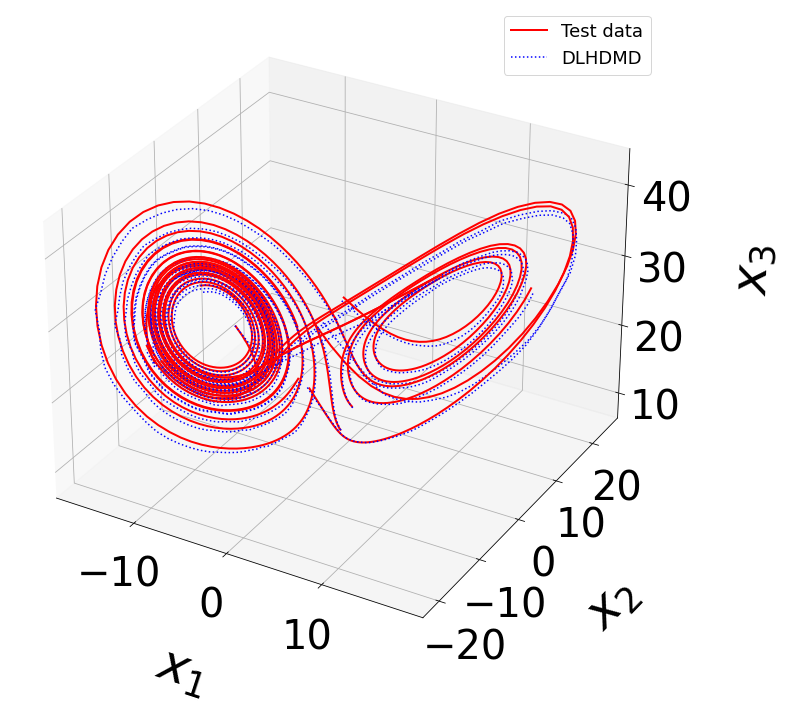

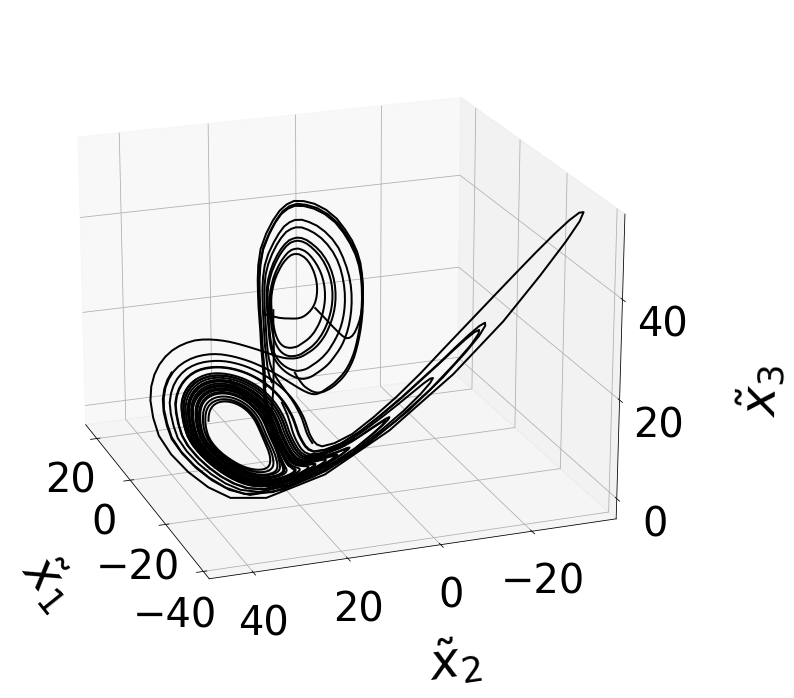

In [25]:
fs = 20
ts = 20
lw = 2.0
ms = 20.0
figsize = (12, 12)
skip = 32

print(np.shape(test_data))
print(np.shape(x_adv))
pred = x_adv.shape[1]

# DLHDMD reconstruction
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=figsize)
ax = fig.add_subplot(1, 1, 1, projection='3d')
for ii in range(0, test_data.shape[0], skip):
    ax.plot3D(test_data[ii, :pred, 0], test_data[ii, :pred, 1], test_data[ii, :pred, 2], color='red', linestyle='solid', lw=lw)
    ax.plot3D(x_adv[ii, :, 0], x_adv[ii, :, 1], x_adv[ii, :, 2], color='blue', linestyle='dotted', ms=ms)
ax.plot3D(test_data[ii, :pred, 0], test_data[ii, :pred, 1], test_data[ii, :pred, 2], color='red', linestyle='solid', lw=lw, label='Test data')
ax.plot3D(x_adv[ii, 0, 0], x_adv[ii, 0, 1], x_adv[ii, 0, 2], color='blue', linestyle='dotted', ms=20*ms, label='DLHDMD')
ax.set_xlabel(r'$x_1$', fontsize=50, labelpad=60.0)
ax.set_ylabel(r'$x_2$', fontsize=50, labelpad=60.0)
ax.set_zlabel(r'$x_3$', fontsize=50, labelpad=60.0)
ax.tick_params(axis='x', labelsize=40, pad=15)
ax.tick_params(axis='y', labelsize=40, pad=15)
ax.tick_params(axis='z', labelsize=40, pad=15)
# ax.set_xticks(np.linspace(-0.05, 0.1, 4))
# plt.gca().view_init(20, 160)
plt.gca()
plt.legend()
# plt.savefig('reconstruction_lorenz1.png', bbox_inches='tight', pad_inches=0.5)

# plt.xlabel(r'$x$', fontsize=fs)
# plt.ylabel(r'$\dot{x}$', fontsize=fs)
# plt.legend(fontsize=fs, loc='upper right')
# plt.axis('equal')
# ax = plt.gca()
# ax.tick_params(axis='both', which='major', labelsize=ts)
# ax.tick_params(axis='both', which='minor', labelsize=ts)
# # plt.savefig("reconstruction_pendulum.png")

# DMD reconstruction
# fig = plt.figure(2, figsize=figsize)
# for ii in range(0, test_data.shape[0], skip):
#     plt.plot(test_data[ii, :, 0], test_data[ii, :, 1], 'k', linestyle='solid', lw=lw)
#     plt.plot(x_pred[ii, :, 0], x_pred[ii, :, 1], 'k', linestyle='dotted', ms=ms)
# plt.plot(test_data[ii, :, 0], test_data[ii, :, 1], 'k', linestyle='solid', lw=lw, label='Test data')
# plt.plot(x_pred[ii, 0, 0], x_pred[ii, 0, 1], 'k', linestyle='dotted', ms=20*ms, label='DMD')
# plt.xlabel(r'$x$', fontsize=fs)
# plt.ylabel(r'$\dot{x}$', fontsize=fs)
# plt.legend(fontsize=fs)
# plt.axis('equal')
# ax = plt.gca()
# ax.tick_params(axis='both', which='major', labelsize=ts)
# ax.tick_params(axis='both', which='minor', labelsize=ts)

# # Plot the trajectories in phase space and latent space
# fig = plt.figure(3, figsize=figsize)
# for ii in range(0, test_data.shape[0], skip):
#     plt.plot(test_data[ii, :, 0], test_data[ii, :, 1], 'k', linestyle='solid', lw=lw)
# plt.xlabel(r'$x$', fontsize=fs)
# plt.ylabel(r'$\dot{x}$', fontsize=fs)
# plt.axis('equal')
# ax = plt.gca()
# ax.tick_params(axis='both', which='major', labelsize=ts)
# ax.tick_params(axis='both', which='minor', labelsize=ts)

# Plot the trajectories in latent space
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1, 1, 1, projection='3d')
for ii in range(0, y_adv.shape[0], skip):
    ax.plot3D(y[ii, :, 0], y[ii, :, 1], y[ii, :, 2], 'k', linestyle='solid', lw=lw)
ax.set_xlabel(r'$\tilde{x}_{1}$', fontsize=50, labelpad=60.0)
ax.set_ylabel(r'$\tilde{x}_{2}$', fontsize=50, labelpad=60.0)
ax.set_zlabel(r'$\tilde{x}_{3}$', fontsize=50, labelpad=60.0)
ax.tick_params(axis='x', labelsize=40, pad=15)
ax.tick_params(axis='y', labelsize=40, pad=15)
ax.tick_params(axis='z', labelsize=40, pad=15)
plt.gca().view_init(20, 160)
# plt.savefig('latent_lorenz1.png', bbox_inches='tight', pad_inches=0.5)

plt.show()